In [22]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Earthquake\ Shelter\ Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1-0g6d2BoKJIreXmqFOQFVso4cDnEhIQt/Earthquake Shelter Project


In [23]:
!pip install pycaret[analysis,models]
import pycaret

In [24]:
import pickle
import tempfile
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, classification_report, recall_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE

from scipy.sparse import csr_matrix

import tensorflow as tf

In [44]:
X_arr = np.load('data/arrays/tokyo_more/x.npy', allow_pickle=True).astype(np.float32)
y_arr = np.load('data/arrays/tokyo_more/y.npy', allow_pickle=True).astype(np.float32)

In [45]:
X_arr.shape, y_arr.shape

((8343, 26), (8343, 1))

In [46]:
X_cols =  ['stories_above_ground',
 'stories_below_ground',
 'steel_frame',
 'reinforced_concrete',
 'lightweight',
 'block',
 'wood',
 'rice_paddy',
 'other_agriculture',
 'forest',
 'wasteland',
 'building',
 'road_transport',
 'rail_transport',
 'other_site',
 'river_wetland',
 'seashore',
 'sea',
 'golf_course',
 'unknown',
 'dist_to_water',
 '0-14',
 '15-64',
 '65+',
 '75+',
 '80+']

In [47]:
df = pd.DataFrame(X_arr, columns=X_cols)
df['shelter'] = y_arr.astype(bool)
df

,stories_above_ground,stories_below_ground,steel_frame,reinforced_concrete,lightweight,block,wood,rice_paddy,other_agriculture,forest,...,sea,golf_course,unknown,dist_to_water,0-14,15-64,65+,75+,80+,shelter
0,9.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.00,0.090000,...,0.0,0.0,0.0,0.000000,350.305908,1995.221802,519.388123,263.713501,157.440308,False
1,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.000000,...,0.0,0.0,0.0,1461.092163,2287.000977,12587.453125,3992.865479,2318.240479,1390.106812,False
2,9.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.00,0.529999,...,0.0,0.0,0.0,0.000000,0.000000,6.304700,2.219200,2.219200,0.566100,False
3,7.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.00,0.000000,...,0.0,0.0,0.0,1461.599365,1574.265259,8389.135742,1818.833130,990.558105,576.055786,False
4,8.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.00,0.010000,...,0.0,0.0,0.0,0.000000,287.540405,1737.067139,475.056610,313.118286,197.522995,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8338,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.03,0.000000,...,0.0,0.0,0.0,1848.158691,2159.213623,12501.012695,4647.344727,2597.618164,1619.281250,False
8339,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.14,0.090000,...,0.0,0.0,0.0,2773.345459,972.371582,5746.816406,3035.598145,1924.226440,1227.879761,True
8340,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.14,0.090000,...,0.0,0.0,0.0,2773.345459,972.371582,5746.816406,3035.598145,1924.226440,1227.879761,False
8341,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.01,0.000000,...,0.0,0.0,0.0,2261.702148,1333.262451,7319.071777,2891.132080,1745.760986,1131.114746,False


In [48]:
X = df.drop(columns=['shelter'])
y = df['shelter']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

smote = SMOTE(random_state=420)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [50]:
df_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)
df_smote['shelter'] = y_train_smote.reset_index(drop=True)

In [51]:
from pycaret.classification import ClassificationExperiment

In [56]:
s = ClassificationExperiment()
s.setup(data=df_smote, target='shelter', session_id=420,
        feature_selection=True, remove_multicollinearity=True, pca=True)

[LightGBM] [Info] Number of positive: 4512, number of negative: 4513
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 9025, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499945 -> initscore=-0.000222
[LightGBM] [Info] Start training from score -0.000222


,Description,Value
0,Session id,420
1,Target,shelter
2,Target type,Binary
3,Original data shape,"(12894, 27)"
4,Transformed data shape,"(12894, 6)"
5,Transformed train set shape,"(9025, 6)"
6,Transformed test set shape,"(3869, 6)"
7,Numeric features,26
8,Preprocess,True
9,Imputation type,simple


In [57]:
best = s.compare_models()
best

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9465,0.9717,0.9415,0.9511,0.9462,0.8930,0.8931,1.3660
rf,Random Forest Classifier,0.9351,0.9751,0.9266,0.9426,0.9345,0.8701,0.8704,2.9360
xgboost,Extreme Gradient Boosting,0.9237,0.9729,0.9253,0.9225,0.9238,0.8473,0.8476,1.0740
dt,Decision Tree Classifier,0.9160,0.9294,0.8841,0.9445,0.9132,0.8320,0.8339,0.5740
lightgbm,Light Gradient Boosting Machine,0.8981,0.9608,0.9056,0.8924,0.8988,0.7961,0.7965,1.6500
catboost,CatBoost Classifier,0.8955,0.9575,0.9102,0.8844,0.8970,0.7910,0.7916,7.6490
knn,K Neighbors Classifier,0.8535,0.9309,0.7937,0.9014,0.8439,0.7070,0.7123,0.7470
gbc,Gradient Boosting Classifier,0.7881,0.8741,0.8364,0.7632,0.7979,0.5763,0.5794,2.4110
ada,Ada Boost Classifier,0.7139,0.7976,0.7675,0.6936,0.7282,0.4278,0.4310,1.3610
qda,Quadratic Discriminant Analysis,0.5975,0.6412,0.7629,0.5733,0.6543,0.1949,0.2074,0.6310


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=420, verbose=0,
                     warm_start=False)

In [58]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

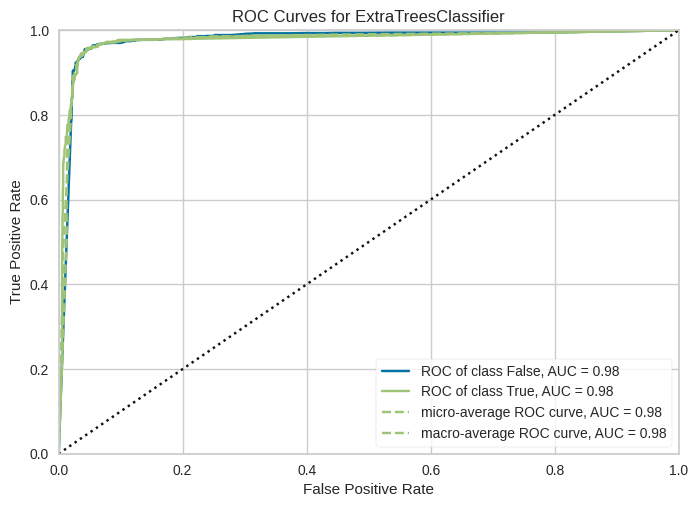

In [59]:
s.plot_model(best, plot='auc')

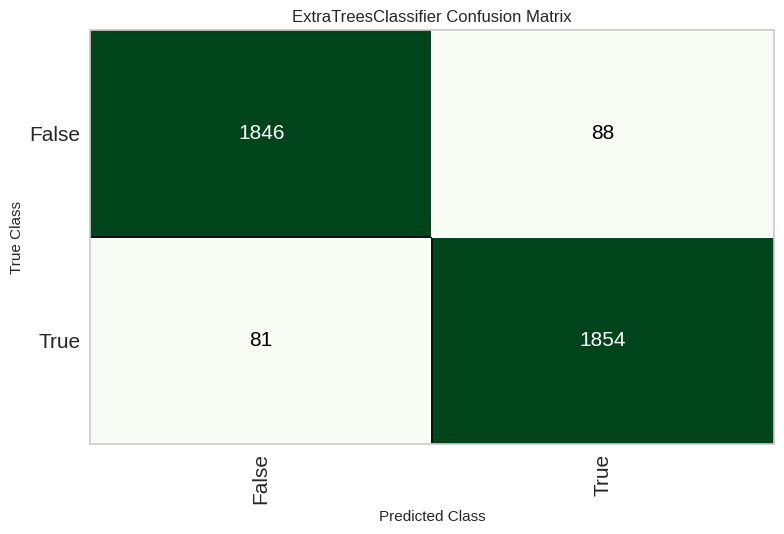

In [60]:
s.plot_model(best, plot='confusion_matrix')

In [61]:
s.predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9563,0.9768,0.9581,0.9547,0.9564,0.9126,0.9126


,stories_above_ground,stories_below_ground,steel_frame,reinforced_concrete,lightweight,block,wood,rice_paddy,other_agriculture,forest,...,unknown,dist_to_water,0-14,15-64,65+,75+,80+,shelter,prediction_label,prediction_score
9480,2.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,0.0,0.03,0.000000,...,0.0,0.000000,1788.169678,9845.723633,3062.606201,1791.383179,1141.944702,True,1,0.8000
8850,3.449013,0.000000,0.224506,1.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,...,0.0,970.830261,2912.055664,18964.865234,5270.688477,3094.919922,1885.481567,True,1,1.0000
8676,2.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,0.0,0.01,0.000000,...,0.0,924.058350,2009.335938,11106.646484,4014.013428,2289.154785,1460.302002,True,1,0.5455
10101,5.727856,0.000000,0.000000,0.681964,0.0,0.0,0.318036,0.0,0.00,0.006820,...,0.0,0.000000,2636.542969,14748.763672,7112.062012,4455.960449,2565.273926,True,1,0.9900
6145,4.000000,1.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.00,0.050000,...,0.0,0.000000,2124.717041,18189.880859,4702.566895,2783.222412,1684.552002,False,1,0.7059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8140,2.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,0.0,0.01,0.000000,...,0.0,0.000000,1003.638977,4847.501465,1640.413330,983.490479,574.252808,True,1,1.0000
285,3.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.00,0.000000,...,0.0,1131.868652,2239.421875,14840.803711,3563.766113,2097.904297,1364.137695,False,0,1.0000
1732,3.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.00,0.000000,...,0.0,0.000000,2107.873291,17415.150391,4703.943359,2785.107422,1730.154053,False,0,1.0000
8378,5.835365,0.708841,0.000000,0.708841,0.0,0.0,0.291159,0.0,0.00,0.198476,...,0.0,0.000000,2181.035645,12006.702148,3657.544678,2041.897217,1215.439697,True,1,0.9100
